# Import Statements

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import OCR_pipeline as OCR
import TopicModeling as TM
import jsonpickle
import gensim

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cleaning And Saving Extracted Text

In [3]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="XXX",
  database="forestry"
)
mycursor = mydb.cursor()

def getExtractedTextsFromCountries(countries):
    sqlStatement = "SELECT P1.filename, P1.pid, P2.country, P1.text from PolicyPaperPages P1 " \
                     "INNER JOIN PolicyPapers P2 " \
                     "on P1.filename = P2.filename WHERE"
    
    for i in range(len(countries)):
        whereClause = " P2.country = '%s' " % countries[i]
        sqlStatement += whereClause
        if len(countries) != 1 and i < len(countries) - 1:
            sqlStatement += "or"

    sqlStatement += "GROUP BY filename, pid ORDER BY filename, pid"
    mycursor.execute(sqlStatement)

    myresult = mycursor.fetchall()
    return combinePages(myresult)

def combinePages(myresult):
    curr_filename = myresult[0][0]
    curr_pages = []
    file_texts = []
    for result in myresult:
        if result[0] != curr_filename:
            file_texts.append([curr_filename, curr_pages])
            curr_pages = []
            curr_filename = result[0]
        else:
            curr_pages.append(str(result[3]))
        
    file_texts.append([curr_filename, curr_pages])
    return file_texts

In [4]:
key_words = ['afforestation','agriculture','animal welfare','artificial regeneration','biodiversity',
             'biological resources','biome','board','clean','coconut','conservation','control','database',
             'enforcement','environment','farm','financing','forest','forest protection','funding','fundraising',
             'land ','land use','landholder','law','measuring','mobilization','monitor','natural resources',
             'oversight','plant breeders','plants','pollution','preservation','produce','protection','qualification',
             'quality','registry','regulation','reporting','reserve','resource','restriction','results-driven',
             'rural','safeguard','species' ,'support','sustainable','technical submission','threatened species',
             'variety','verification','wastewater','water','watershed','wild life']

In [5]:
spanish_key_words = ['repoblación forestal', 'agricultura', 'bienestar de los animales', 'regeneración artificial', 
                     'biodiversidad', 'recursos biologicos', 'bioma', 'tablero', 'limpiar', 'Coco', 'conservación',
                     'controlar', 'base de datos', 'aplicación', 'ambiente', 'granja', 'financiación', 'bosque', 
                     'protección forestal', 'fondos', 'recaudación de fondos', 'tierra', 'uso del suelo', 
                     'terrateniente', 'ley', 'medición', 'movilización', 'monitor', 'recursos naturales', 'vigilancia',
                     'fitomejoradores', 'plantas', 'contaminación', 'preservación', 'Produce', 'proteccion',
                     'calificación', 'calidad', 'registro', 'regulación', 'reportando', 'reserva', 'recurso', 
                     'restricción', 'impulsado por resultados', 'rural', 'salvaguardia', 'especies', 'apoyo', 
                     'sostenible', 'sumisión técnica', 'especies amenazadas', 'variedad', 'verificación', 
                     'aguas residuales', 'agua', 'cuenca', 'fauna silvestre']

In [6]:
#dictionary for texts in terms of sentences
import re
import gc
textDictionary = {}
countries = ['India']
policyPapers = getExtractedTextsFromCountries(countries)
language_keywords = {}
language_keywords['english'] = key_words
language_keywords['spanish'] = spanish_key_words
for paper in policyPapers:
    full_text = ' '.join(paper[1])
    cleanedText = TM.toSentences(full_text, 'english', language_keywords['english'])
    textDictionary[paper[0]] = cleanedText

# LDA

In [7]:
from pprint import pprint
lemmatized_sents = []

# Print the Keywords in the 5 topics
for key in textDictionary:
    cleanedText = textDictionary[key]
    lemmatized_sents.extend(cleanedText)
    
corpus, lda_model = TM.LDA(lemmatized_sents)
pprint(lda_model.print_topics(-1))
doc_lda = lda_model[corpus]
#Next Step: Store LDA data in Policy Paper Object & other central file

[(0,
  '0.038*"livestock" + 0.031*"market" + 0.023*"product" + 0.020*"produce" + '
  '0.019*"notify" + 0.018*"committee" + 0.016*"agricultural" + 0.012*"shall" + '
  '0.011*"mean" + 0.010*"sale"'),
 (1,
  '0.021*"member" + 0.013*"india" + 0.012*"government" + 0.012*"organisation" '
  '+ 0.012*"forest" + 0.011*"environment" + 0.011*"water" + 0.009*"epco" + '
  '0.009*"skmccc" + 0.008*"director"'),
 (2,
  '0.040*"water" + 0.020*"area" + 0.017*"agriculture" + 0.015*"high" + '
  '0.014*"resource" + 0.014*"irrigation" + 0.013*"ground" + '
  '0.012*"groundwater" + 0.011*"use" + 0.011*"crop"'),
 (3,
  '0.020*"area" + 0.020*"forest" + 0.017*"person" + 0.016*"officer" + '
  '0.015*"property" + 0.011*"land" + 0.011*"offence" + 0.009*"commit" + '
  '0.008*"shall" + 0.008*"government"'),
 (4,
  '0.043*"water" + 0.015*"fish" + 0.011*"state" + 0.011*"practice" + '
  '0.010*"increase" + 0.010*"climatic" + 0.010*"agro" + 0.010*"availability" + '
  '0.009*"different" + 0.009*"seed"'),
 (5,
  '0.020*"ch

In [8]:
# Save LDA
lda_model.save("lda_model")

In [9]:
# Load LDA

lda_saved = gensim.models.ldamodel.LdaModel.load("lda_model")

In [10]:
lda_saved.print_topics(-1)

[(0,
  '0.038*"livestock" + 0.031*"market" + 0.023*"product" + 0.020*"produce" + 0.019*"notify" + 0.018*"committee" + 0.016*"agricultural" + 0.012*"shall" + 0.011*"mean" + 0.010*"sale"'),
 (1,
  '0.021*"member" + 0.013*"india" + 0.012*"government" + 0.012*"organisation" + 0.012*"forest" + 0.011*"environment" + 0.011*"water" + 0.009*"epco" + 0.009*"skmccc" + 0.008*"director"'),
 (2,
  '0.040*"water" + 0.020*"area" + 0.017*"agriculture" + 0.015*"high" + 0.014*"resource" + 0.014*"irrigation" + 0.013*"ground" + 0.012*"groundwater" + 0.011*"use" + 0.011*"crop"'),
 (3,
  '0.020*"area" + 0.020*"forest" + 0.017*"person" + 0.016*"officer" + 0.015*"property" + 0.011*"land" + 0.011*"offence" + 0.009*"commit" + 0.008*"shall" + 0.008*"government"'),
 (4,
  '0.043*"water" + 0.015*"fish" + 0.011*"state" + 0.011*"practice" + 0.010*"increase" + 0.010*"climatic" + 0.010*"agro" + 0.010*"availability" + 0.009*"different" + 0.009*"seed"'),
 (5,
  '0.020*"change" + 0.018*"development" + 0.017*"climate" + 0.

In [11]:
output = lda_model.print_topics(-1)
test = output[0][1]
test.split("+")

['0.038*"livestock" ',
 ' 0.031*"market" ',
 ' 0.023*"product" ',
 ' 0.020*"produce" ',
 ' 0.019*"notify" ',
 ' 0.018*"committee" ',
 ' 0.016*"agricultural" ',
 ' 0.012*"shall" ',
 ' 0.011*"mean" ',
 ' 0.010*"sale"']

In [14]:
import operator

def top_three_topics(lda_model, text):
    preprocess = simple_preprocess(text)
    common_dictionary = Dictionary([text.split(" ")])
    bow = common_dictionary.doc2bow(preprocess)
    
    document_topics = lda_model.get_document_topics(bow)
    topics_ratio = dict(document_topics)
    
    top_three = []
    for i in range(0, 3):
        try: 
            largest = max(topics_ratio.items(), key=operator.itemgetter(1))
            top_three.append(largest)
            del topics_ratio[largest[0]]
        except: 
            return top_three
    
    return top_three

In [15]:
# Preparation cell for get_document topics. Preprocessing
from gensim.corpora.dictionary import Dictionary
from gensim.utils import simple_preprocess, simple_tokenize

text = policyPapers[0][1]

j=0
for doc in policyPapers:
    i = 1
    j+=1
    print(doc[0])
    for page in doc[1]:
        topics = top_three_topics(lda_saved, page)
        print("Page ", i, topics)
        i += 1
    if j == 5:
        break

_MineralConservationandDevelopmentRules1988-converted.pdf
Page  1 [(6, 0.84288186), (13, 0.12565221), (1, 0.029402895)]
Page  2 [(6, 0.6724807), (13, 0.2167288), (0, 0.10938124)]
Page  3 [(6, 0.7781306), (1, 0.1015739), (13, 0.097675696)]
Page  4 [(6, 0.9223643), (13, 0.07647874)]
Page  5 [(6, 0.7912127), (13, 0.101194896), (11, 0.07174407)]
Page  6 [(6, 0.64769083), (13, 0.28910452), (1, 0.062068794)]
Page  7 [(6, 0.814134), (13, 0.15356685), (10, 0.03149255)]
Page  8 [(6, 0.67749655), (13, 0.3215213)]
Page  9 [(6, 0.7869146), (13, 0.16607806), (1, 0.031022845)]
Page  10 [(6, 0.766769), (10, 0.12336112), (13, 0.108846836)]
Page  11 [(6, 0.55113494), (12, 0.14364257), (13, 0.12898512)]
Page  12 [(6, 0.8501202), (13, 0.11513037), (3, 0.03403629)]
Page  13 [(6, 0.7860333), (13, 0.14133091), (3, 0.07196711)]
Page  14 [(6, 0.61162895), (13, 0.2410278), (3, 0.059243817)]
Page  15 [(6, 0.82331127), (13, 0.1589382), (1, 0.01652292)]
Page  16 [(6, 0.8956937), (13, 0.10292422)]
Page  17 [(6, 0.

Page  35 [(6, 0.70290995), (13, 0.21849717), (3, 0.030487621)]
Page  36 [(6, 0.9048638), (13, 0.09382031)]
Page  37 [(6, 0.48184124), (13, 0.28055924), (3, 0.09293415)]
Page  38 [(6, 0.55789596), (1, 0.23763211), (13, 0.15486032)]
Page  39 [(6, 0.77642035), (13, 0.14610246), (3, 0.0485406)]
Page  40 [(6, 0.65456986), (13, 0.34434545)]
Page  41 [(6, 0.83828646), (13, 0.160567)]
Page  42 [(6, 0.6546089), (13, 0.19055213), (1, 0.10754281)]
Page  43 [(6, 0.6444875), (13, 0.29764748), (11, 0.037708264)]
Page  44 [(6, 0.65405965), (13, 0.1735824), (12, 0.11249008)]
Page  45 [(6, 0.7108581), (13, 0.21539082), (3, 0.028997153)]
Page  46 [(6, 0.77344185), (13, 0.17344776), (3, 0.051306542)]
Page  47 [(6, 0.56990385), (13, 0.34632394), (11, 0.082315296)]
Page  48 [(6, 0.8227276), (13, 0.14881933), (10, 0.027582264)]
Page  49 [(6, 0.8620801), (13, 0.13666861)]
Page  50 [(6, 0.87850285), (13, 0.0776477), (1, 0.042488616)]
Page  51 [(6, 0.72649986), (13, 0.19339032), (1, 0.05490741)]
Page  52 [(6, 

In [11]:
# Top Three proportions of topics. 
top_three

[(6, 0.1584916), (23, 0.11156807), (29, 0.08449893)]

In [12]:
# Retrieve the three topics for this specific document
topics = []
for item in top_three:
    topics.append(output[item[0]])
topics

[(6,
  '0.040*"shall" + 0.029*"government" + 0.023*"state" + 0.021*"lessee" + 0.018*"mineral" + 0.018*"mining" + 0.017*"land" + 0.016*"lease" + 0.012*"operation" + 0.012*"say"'),
 (23,
  '0.028*"water" + 0.024*"high" + 0.016*"wrd" + 0.012*"fish" + 0.011*"use" + 0.011*"produce" + 0.010*"practice" + 0.009*"irrigation" + 0.009*"availability" + 0.009*"area"'),
 (29,
  '0.064*"water" + 0.014*"coconut" + 0.013*"management" + 0.012*"area" + 0.012*"urban" + 0.011*"industrial" + 0.010*"waste" + 0.010*"development" + 0.009*"reduce" + 0.009*"wrd"')]

In [59]:
my = lda_model.print_topics()[0][1]

In [60]:
re.findall(r"[a-zA-Z]+",my)

['mean',
 'include',
 'tree',
 'wood',
 'forest',
 'soil',
 'secretary',
 'natural',
 'plant',
 'state']

## Extract sentences by Keywords

### TODO: Have a feature on the web app so that the user can extract text using keywords

In [12]:
#Try with the first document
policy_0 = policyPapers[0][1]
sentences = TM.ReturnSentence(policy_0)

In [13]:
#This can be used as a preview feature
for s in sentences:
    if 'land' in s:
        print(s)

Definitions:Intheserules,unlessthecontextotherwiserequires:(a) “abandonmentofmine”meansfinalclosureofamineeitherwholeorpartthereofwhenthemineraldepositswithinmineorpartthereof,havebeenfullyextractedorwhentheminingoperationshavebecomeuneconomic;(aa)"Act"meanstheMinesandMinerals(DevelopmentandRegulation)Act,1957(67of1957);(b)"agent",whenusedinrelationtoamine,meansanypersonwhetherappointedassuchornot,whoactsastherepresentativeoftheownerinrespectofthemanagementofthemineoranypartthereof;(c)"authorisedofficer"meansanyofficeroftheIndianBureauofminesdulyauthorisedinwritingbytheControllerGeneral,IndianBureauofMinestoperformthefunctionsundertheserules;(d)"beneficiation"meansprocessingofmineralsororesforthepurposeof–(i)regulatingthesizeofadesiredproduce;(ii)removingunwantedconstituents;and(iii)improvingquality,purityorassaygradeofdesiredproduct:(e)"Boring"or"drilling"meansthepenetrationofalluvialmaterial,rocksorformationsbyholesforobtaininggeologicalinformation,andfordrawingsamplestherefrom;(f)"

## Use Key Words to classify documents

In [14]:
key_words = ['afforestation','agriculture','animal welfare','artificial regeneration','biodiversity',
             'biological resources','biome','board','clean','coconut','conservation','control','database',
             'enforcement','environment','farm','financing','forest','forest protection','funding','fundraising',
             'land ','land use','landholder','law','measuring','mobilization','monitor','natural resources',
             'oversight','plant breeders','plants','pollution','preservation','produce','protection','qualification',
             'quality','registry','regulation','reporting','reserve','resource','restriction','results-driven',
             'rural','safeguard','species' ,'support','sustainable','technical submission','threatened species',
             'variety','verification','wastewater','water','watershed','wild life']

In [15]:
'artificial regeneration' in cleanWhitespaces

False

# Visualizations

### pyLDAvis

`pip install pyldavis`

Code source: https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
<br>
The area of the circles represent the prevalance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. 

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# p = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# pyLDAvis.save_html(p, 'pyLDAvis.html')

/Users/kimberly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.108170 -0.222605       1        1  9.977398
23    -0.308360  0.093331       2        1  7.004554
1      0.120486 -0.020219       3        1  6.020911
14    -0.066176 -0.144758       4        1  5.517766
26     0.076776  0.056168       5        1  5.206272
15    -0.049348 -0.200599       6        1  5.197754
7     -0.056595 -0.149595       7        1  5.062363
8     -0.176473  0.102075       8        1  4.058579
6     -0.133494  0.042576       9        1  3.647604
4     -0.114422  0.100660      10        1  3.642480
12     0.045433 -0.006443      11        1  3.309581
29    -0.026427  0.005822      12        1  3.067155
2     -0.030908  0.064425      13        1  3.043777
16     0.083434  0.030994      14        1  2.838611
25     0.062264 -0.029634      15        1  2.811863
0      0.013552 -0.023984      16        1  2.700323
5      0.087363  0.009057      17        1  2.520531
24    -0.019712  0.095645      18        1  2.517176
22    -0.057781  0.013224      19        1  2.372691
28     0.012642  0.023681      20        1  2.326129
11     0.046768  0.058111      21        1  2.173433
17     0.073848  0.032038      22        1  2.169999
19     0.100164  0.003887      23        1  2.028180
18     0.017375 -0.023960      24        1  1.869620
3      0.038397 -0.027420      25        1  1.816598
9      0.098346  0.056286      26        1  1.742032
10     0.063925  0.043517      27        1  1.543170
21     0.087009 -0.007557      28        1  1.352816
27     0.075218  0.028898      29        1  1.308478
20     0.044867 -0.003621      30        1  1.152150, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
127   Default  187.000000          section  187.000000  30.0000  30.0000
567   Default  134.000000              sec  134.000000  29.0000  29.0000
3480  Default  109.000000              fig  109.000000  28.0000  28.0000
30    Default   72.000000             rule   72.000000  27.0000  27.0000
4280  Default   76.000000             uadd   76.000000  26.0000  26.0000
4221  Default   83.000000             high   83.000000  25.0000  25.0000
4113  Default   46.000000              wrd   46.000000  24.0000  24.0000
3355  Default  295.000000             epco  295.000000  23.0000  23.0000
197   Default   97.000000               rs   97.000000  22.0000  22.0000
3363  Default  217.000000           skmccc  217.000000  21.0000  21.0000
4288  Default   42.000000             nmsh   42.000000  20.0000  20.0000
3483  Default  102.000000             gomp  102.000000  19.0000  19.0000
4213  Default   35.000000              doa   35.000000  18.0000  18.0000
2772  Default   58.000000            table   58.000000  17.0000  17.0000
642   Default   69.000000        ofsection   69.000000  16.0000  16.0000
2942  Default   31.000000           member   31.000000  15.0000  15.0000
32    Default   48.000000   asthecasemaybe   48.000000  14.0000  14.0000
2138  Default   27.000000        thelessee   27.000000  13.0000  13.0000
4210  Default   67.000000  butnotlimitedto   67.000000  12.0000  12.0000
4222  Default   67.000000             incr   67.000000  11.0000  11.0000
4251  Default   34.000000       coordinate   34.000000  10.0000  10.0000
2544  Default   25.000000            crore   25.000000   9.0000   9.0000
4242  Default   38.000000       skmccchigh   38.000000   8.0000   8.0000
4208  Default   50.000000        bilateral   50.000000   7.0000   7.0000
68    Default   62.000000            ifany   62.000000   6.0000   6.0000
4446  Default   31.000000              doe   31.000000   5.0000   5.0000
3157  Default   42.000000              doc   42.000000   4.0000   4.0000
2815  Default   44.000000       background   44.000000   3.0000   3.0000
45    Default   24.000000           ofrule   24.000000   2.0000   2.000

### WordCloud

`pip install wordcloud`

Code source: https://medium.com/@rudyb2001/making-sense-of-the-news-using-machine-learning-e13ed5f96cf0
<br>
WordCloud of Top 10 words in each topic with the sizes of the words proportional to the weights.

In [113]:
len(lda_model.show_topics(formatted=False))

10

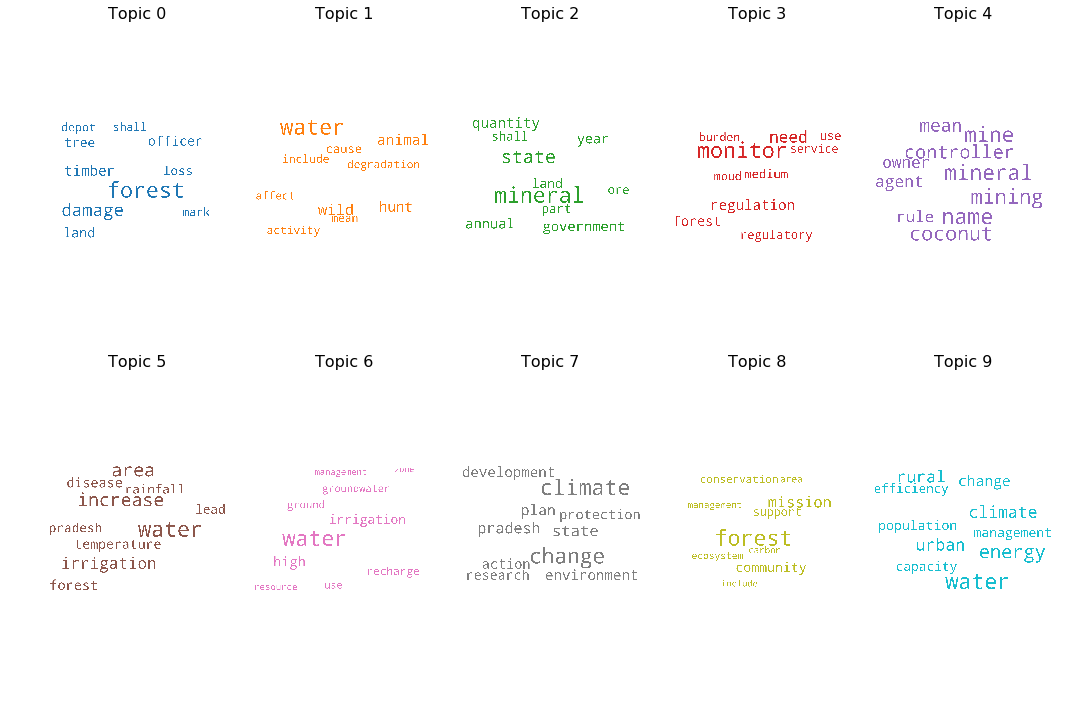

In [114]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Storage